In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

In [183]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
brown2 = '#B45419'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
teal1 = '#294839'
green1 = '#6DA08C'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#7A693B'
beige2 = '#A89677'
beige3 = '#D2CDAD'
grey1 = '#E7E7E7'
grey2 = '#D7D7D7'
grey3 = '#C6C6C6'
grey4 = '#939393'
blue1 = '#3EA1C0'

In [184]:
NoOfPeakSeason = 2
lengthPeakSeason = 24
NoOfRegSeason = 4
lengthRegSeason = 168
season_scale = [(8760 - NoOfPeakSeason * lengthPeakSeason) / NoOfRegSeason / lengthRegSeason
                            for x in range(NoOfRegSeason)] + [1 for x in range(NoOfPeakSeason)]
new_names = ['CCGT',   'OCGT',  'Biomass',  'Oil'  ,'Wind', 'Solar', 'Hydro ror', 'Hydro storage', 'Geothermal']
new_names_2 = ['CCGT',   'OCGT',  'Biomass',  'Oil'  ,'Wind', 'Solar', 'Hydro', 'Geothermal']
old_names = ['GasCCGT',    'GasOCGT',  'Bio',   'Oilexisting',  'Windonshore',  'Solar'  ,'Hydrorun-of-the-river', 'Hydroregulated', 'Geo']
scenario = '1'
date = '0506'
time = '1606'

# Initialize dictionaries to store file paths and data frames
file_paths = {}
operational_data_frames = {}
objective_values = {}
times = ["1455", "1500", "1504", "1507", "1511", "1515", "1518", "1522", "1525", "1530"]
for time in times:
    file_path = f'Results/bolivia_v1_reg{lengthRegSeason}_peak24_sce{scenario}_randomSGR_2024{date}{time}/results_output_EuropePlot.csv'
    operational_data = f'Results/bolivia_v1_reg{lengthRegSeason}_peak24_sce{scenario}_randomSGR_2024{date}{time}/results_output_Operational.csv'
    objective_value = f'Results/bolivia_v1_reg{lengthRegSeason}_peak24_sce{scenario}_randomSGR_2024{date}{time}/results_objective.csv'
    objective_value = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak24_sce' + scenario + '_randomSGR_2024' + date + time +'/results_objective.csv', header=None)

    file_paths[time] = file_path
    operational_data_frames[time] = operational_data
    objective_values[time] = objective_value.iloc[0,1] /1e9
    

In [185]:
# Helper functions
def get_colors(carriers):
    colors = [beige2, beige3, green2, beige1, teal4, yellow, teal2, brown2]
    color_dict = dict(zip(new_names_2, colors))
    colors_new = [color_dict[carrier] for carrier in carriers]
    return colors_new

def rename_columns(df):
    name_map= dict(zip(old_names, new_names))
    df = df.rename(columns=name_map)
    return df

def open_csv(file, included_rows):
    data_list = []
    with open(file, 'r') as f:
        next(f)
        headers = f.readline().strip().split(',')  # Read the first line to get headers
        for i, line in enumerate(f, start=2):  # Start counting from 2 since headers are at line 1
            if i in included_rows:
                # Split the line by comma, or change delimiter as necessary
                values = line.strip().split(',')
                # Create a dictionary for the row using a dictionary comprehension and zip to pair headers and values
                row_data = dict(zip(headers, values))
                data_list.append(row_data)
    return pd.DataFrame(data_list)

def rename_columns_operations(df):
    operations_names = ['GasCCGT_MW', 'GasOCGT_MW', 'Bio_MW', 'Oilexisting_MW', 'Windonshore_MW', 'Solar_MW', 'Hydrorun-of-the-river_MW', 'Hydroregulated_MW', 'Geo_MW']
    name_map= dict(zip(operations_names, new_names))
    df = df.rename(columns=name_map)
    return df

# Order columns in this order: CCGT, OCGT, Oil, Geothermal, Hydro, Wind, Solar, Biomass 
column_order = ['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']

def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

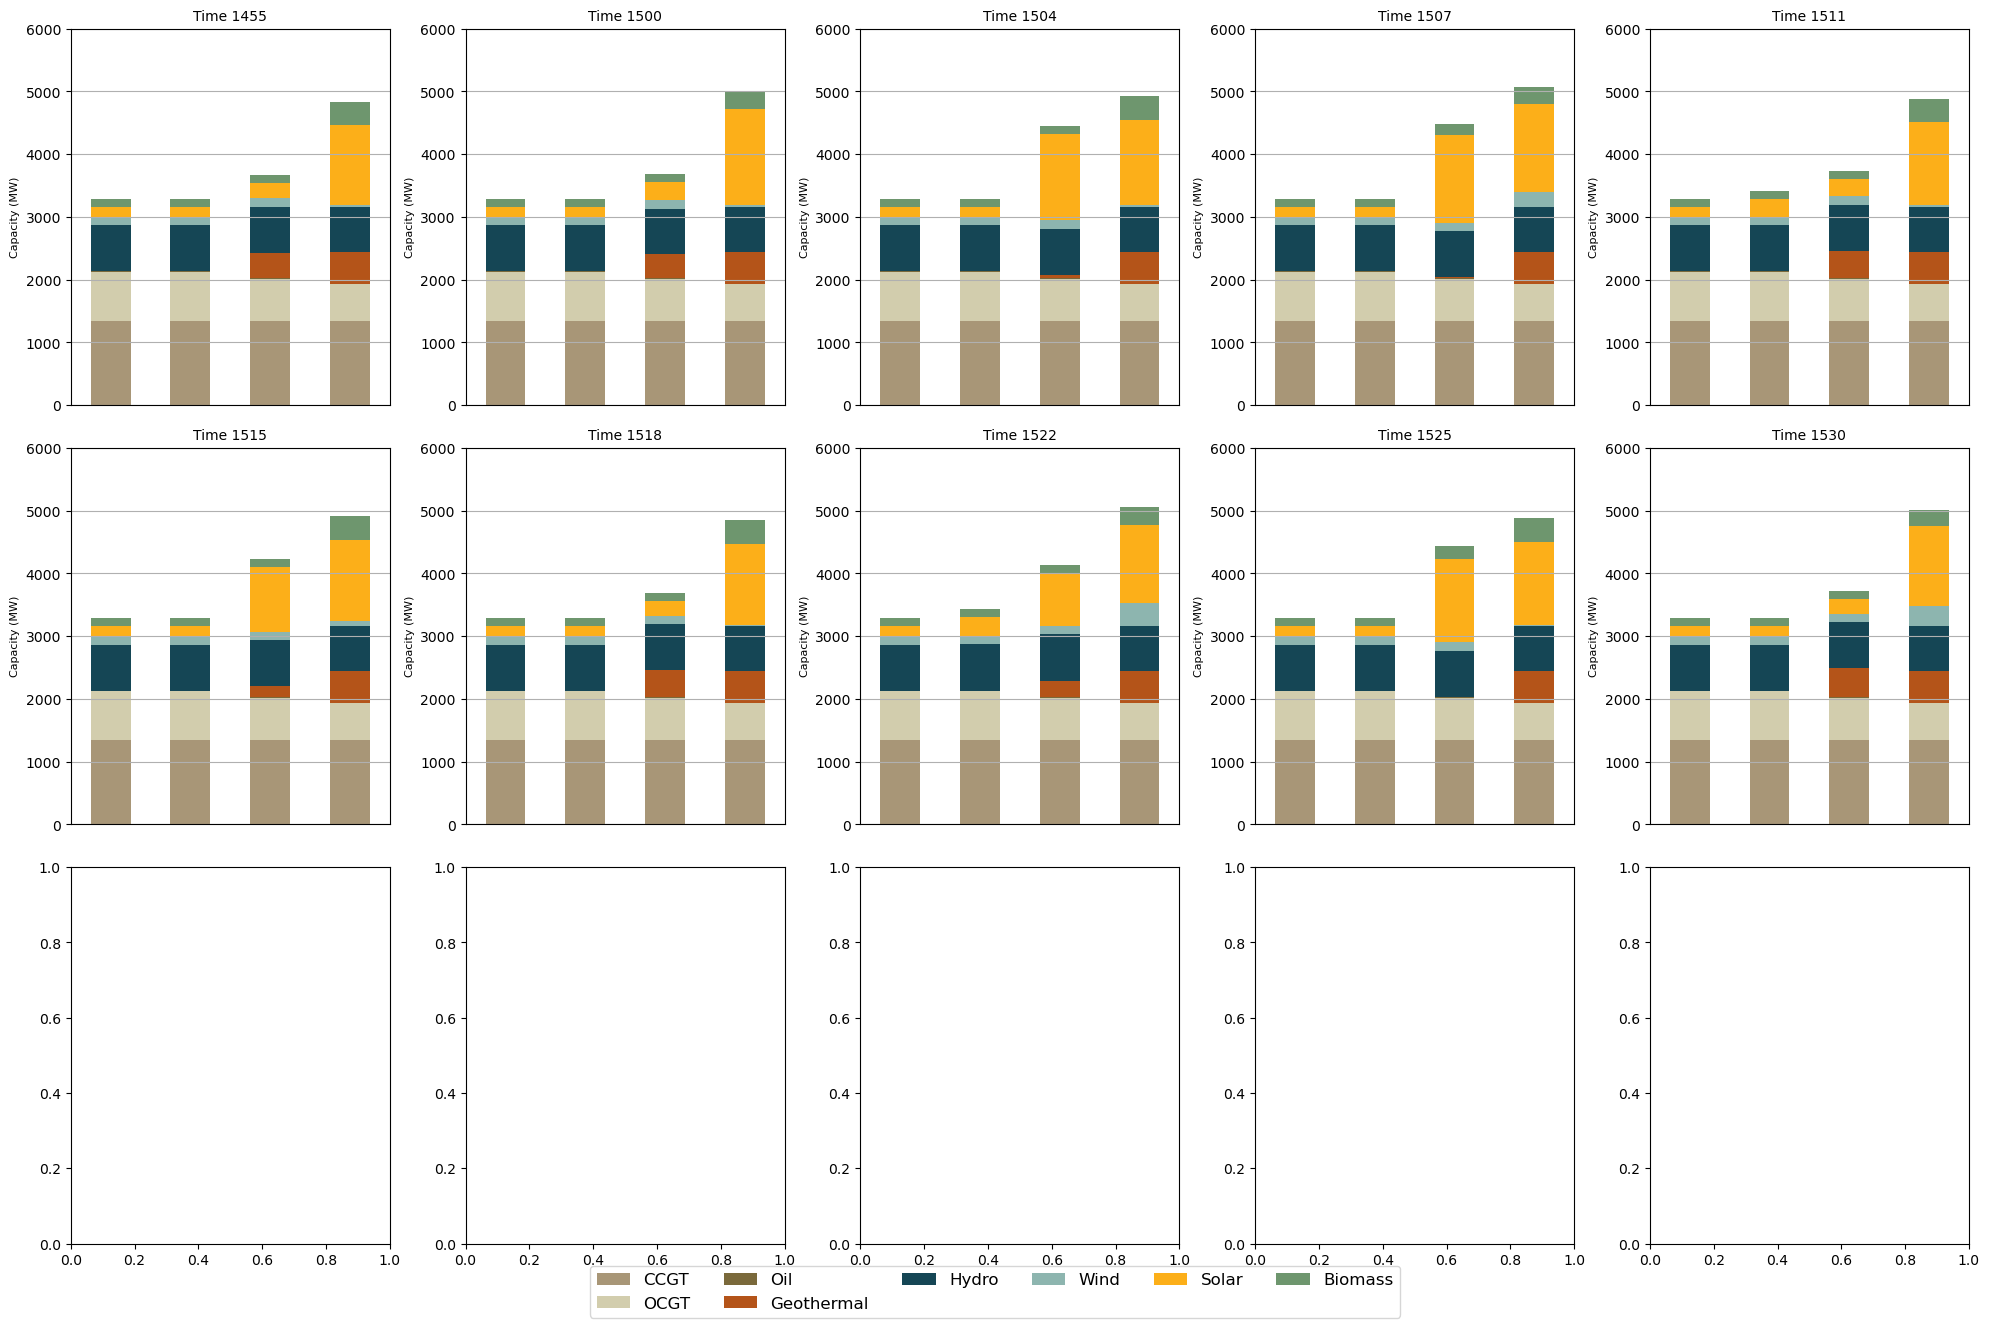

              CCGT    OCGT    Oil    Geothermal       Hydro   Wind  \
                                                                     
Initial    1343.07  774.68  12.00  0.000000e+00  734.850000  131.4   
2030-2035  1343.07  774.68  12.00  6.314878e-16  734.850000  131.4   
2035-2040  1343.07  673.02   8.66  4.035307e+02  734.156558  131.4   
2040-2045  1343.07  587.99   6.46  5.100000e+02  708.628669   27.0   

                 Solar     Biomass  
                                    
Initial     165.080000  127.720000  
2030-2035   165.080000  127.720000  
2035-2040   252.344369  127.720000  
2040-2045  1288.996437  360.230285  


In [194]:
# Setup figure and subplots
fig, axes = plt.subplots(3, 5, figsize=(20, 14))  # Adjust the size as needed
axes = axes.flatten()  # Flatten the axes array for easy looping

# Create a dictionary to store processed dataframes for each time
installed_cap_dataframes = {}

included_rows = [2, 3, 4, 5]
for index, (time, path) in enumerate(file_paths.items()):
    # Load and process installed capacity data
    installed_cap = open_csv(path, included_rows)
    installed_cap.set_index("", inplace=True)
    for column in installed_cap.columns:
        installed_cap[column] = pd.to_numeric(installed_cap[column], errors='coerce')

    installed_cap = rename_columns(installed_cap)
    installed_cap['Hydro'] = installed_cap['Hydro ror'] + installed_cap['Hydro storage']
    installed_cap.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)
    installed_cap_dataframes[time] = installed_cap[column_order]

# Plotting
for index, (time, installed_cap) in enumerate(installed_cap_dataframes.items()):
    ax = axes[index]
    installed_cap.plot(kind='bar', stacked=True, ax=ax, color=get_colors(installed_cap.columns), legend=False)
    ax.set_title(f"Time {time}", fontsize=10)
    ax.set_ylabel('Capacity (MW)', fontsize=8)
    ax.set_xticks([])  # Remove x-ticks
    ax.set_ylim(0, 6000)
    ax.grid(True)

# Adjust layout and add a common legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect to make space for the legend

plt.show()
print(installed_cap_dataframes['1455'])

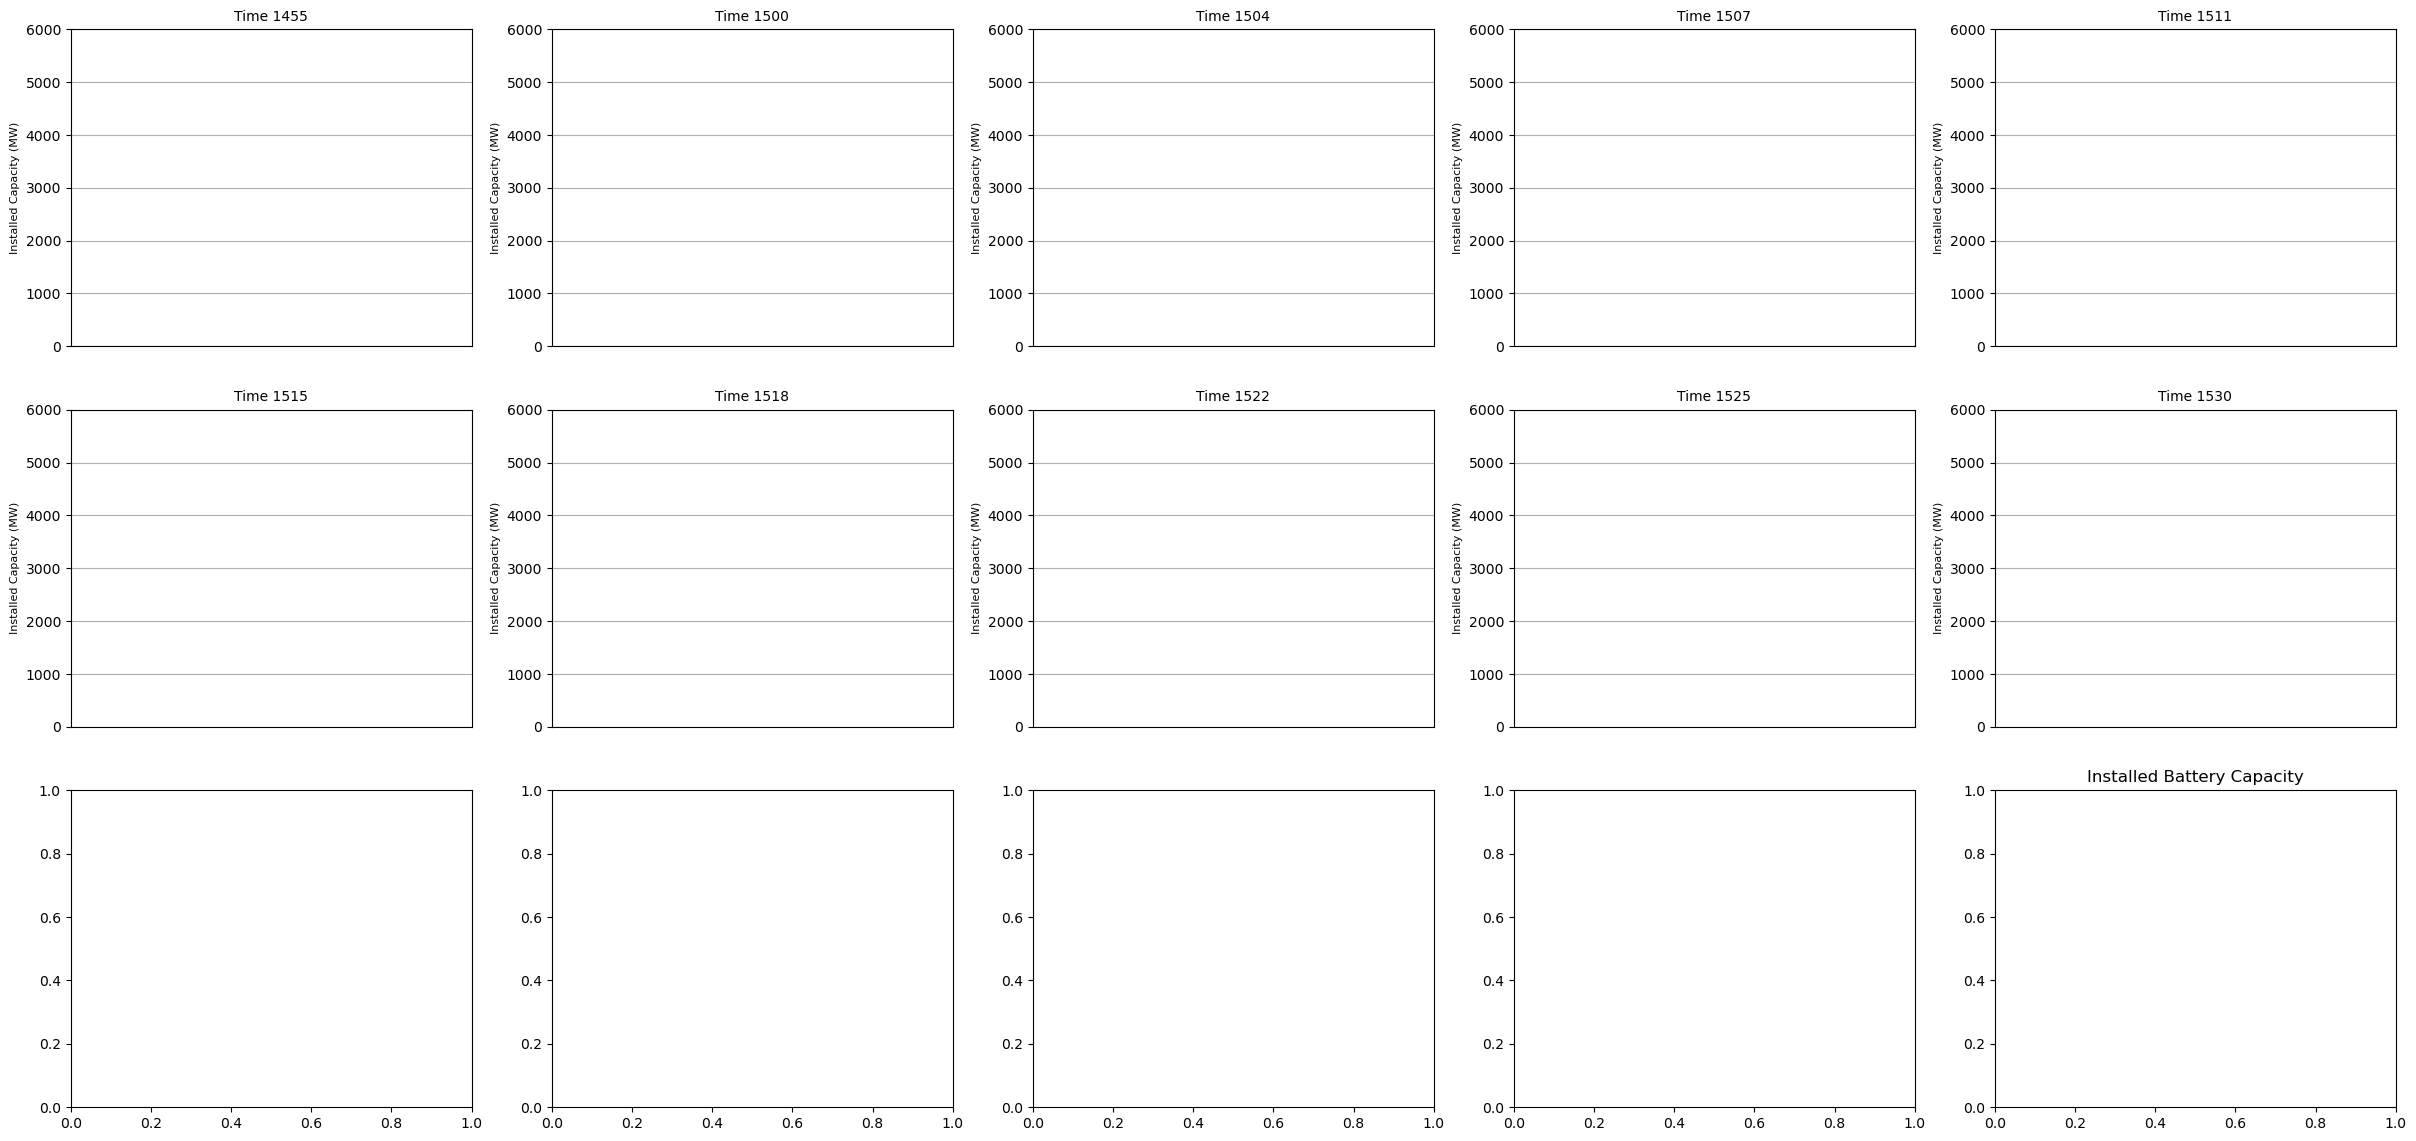

In [187]:
# Setup figure and subplots
fig, axes = plt.subplots(3, 5, figsize=(30, 14))  # Adjust the size as needed
axes = axes.flatten()  # Flatten the axes array for easy looping

included_rows = [21, 22, 23]
for ax, (time, path) in zip(axes, file_paths.items()):
    installed_battery = open_csv(path, included_rows)
    installed_battery.set_index(installed_battery.columns[0], inplace=True)

    for column in installed_battery.columns:
        installed_battery[column] = pd.to_numeric(installed_battery[column], errors='coerce')

    installed_battery.plot(kind='bar', stacked=True, color=teal2, ax=ax, legend=False)

    # Adding titles and labels
    ax.set_title(f"Time {time}", fontsize=10)
    ax.set_ylabel('Installed Capacity (MW)', fontsize=8)
    ax.set_xticks([])
    ax.set_ylim(0, 6000)
    ax.grid(axis='y')
plt.title('Installed Battery Capacity', fontsize=12)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


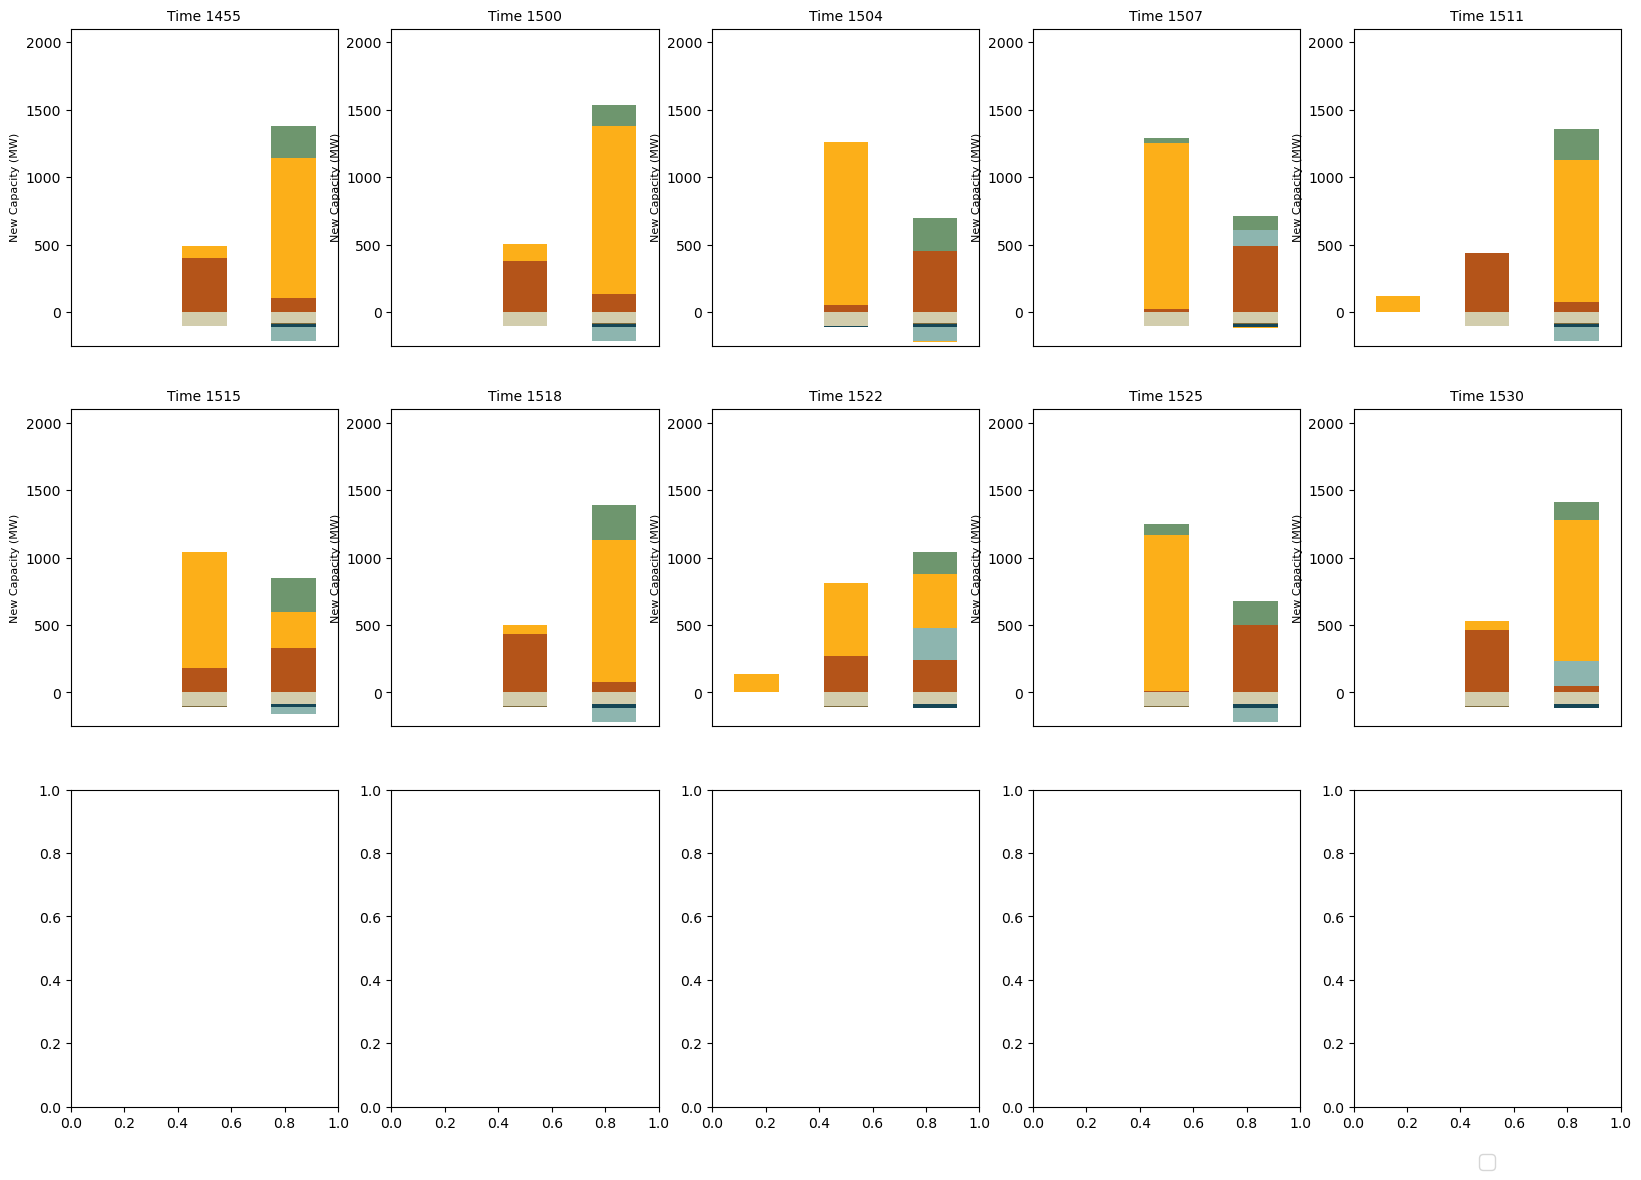

In [188]:
# Setup figure and subplots
fig, axes = plt.subplots(3, 5, figsize=(20, 14))  # Adjust the size as needed
axes = axes.flatten()  # Flatten the axes array for easy looping

for index, (time, path) in enumerate(file_paths.items()):
    ax = axes[index]
    # New installed capacity
    
    new_installed_cap = installed_cap_dataframes[time].diff()
    new_installed_cap = rename_columns(new_installed_cap)
    # new_installed_cap['Hydro'] = new_installed_cap['Hydro ror'] + new_installed_cap['Hydro storage']
    # new_installed_cap.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)
    new_installed_cap = new_installed_cap.dropna()
    new_installed_cap = new_installed_cap[column_order]
    new_installed_cap.plot(kind='bar', stacked=True, ax = ax, color=get_colors(new_installed_cap.columns), legend=False)
    ax.set_title(f"Time {time}", fontsize=10)
    ax.set_ylabel('New Capacity (MW)', fontsize=8)
    ax.set_xticks([])  # Remove x-ticks
    ax.set_ylim(-250, 2100)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14)
plt.show()


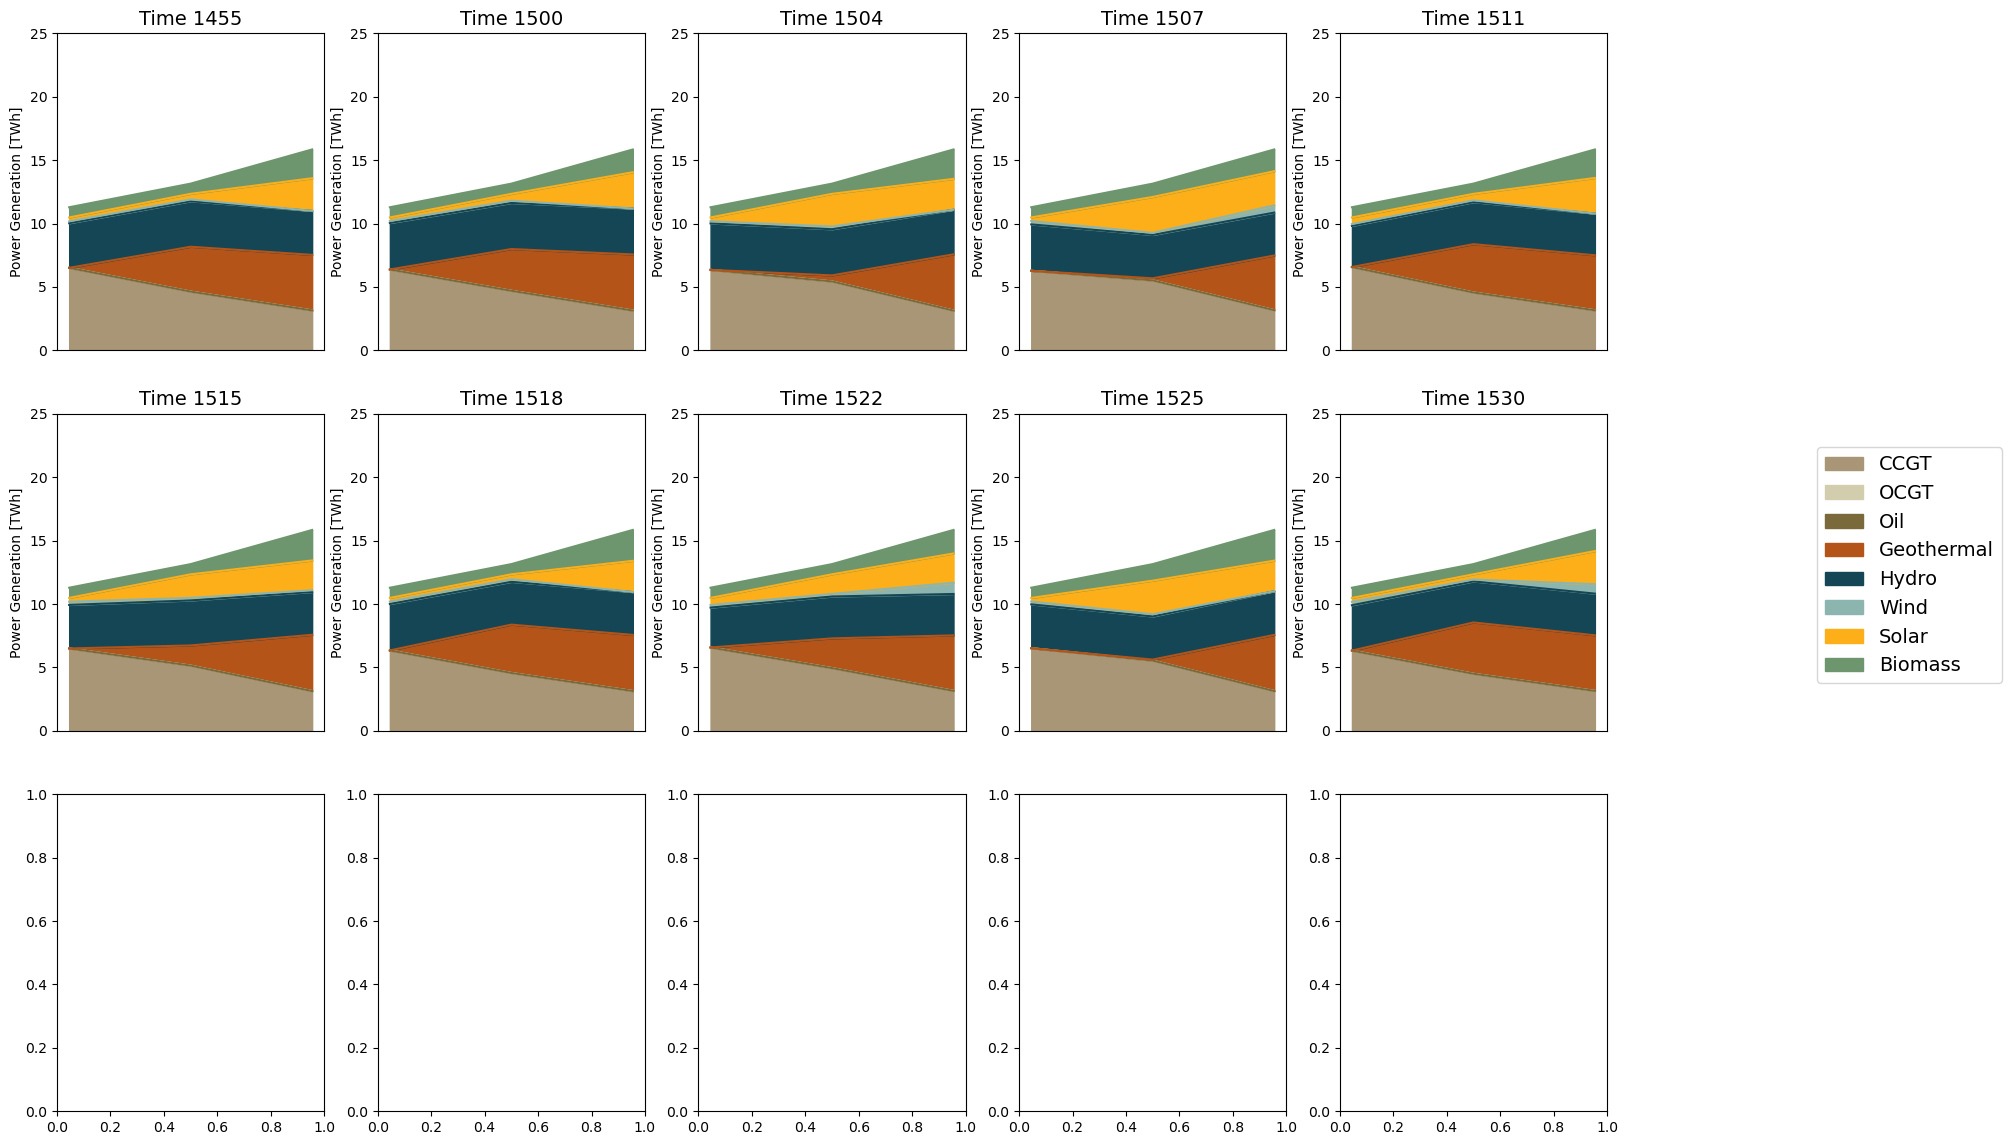

In [189]:
included_rows = [9,10,11]

# Setup figure and subplots
fig, axes = plt.subplots(3, 5, figsize=(20, 14))  # Adjust the size as needed
axes = axes.flatten()  # Flatten the axes array for easy looping

for ax, (time, path) in zip(axes, file_paths.items()):
    dispatch = open_csv(path, included_rows)
    dispatch.set_index('', inplace=True)
    for column in dispatch.columns:
        dispatch[column] = pd.to_numeric(dispatch[column], errors='coerce')
        
    dispatch = rename_columns(dispatch)
    dispatch /= 1000

    dispatch['Hydro'] = dispatch['Hydro ror'] + dispatch['Hydro storage']
    dispatch.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)

    # Order the columns in the same way as the installed capacity
    dispatch = dispatch[new_installed_cap.columns]

    # Plot area chart
    dispatch.plot.area(stacked=True, color=get_colors(dispatch.columns), ax=ax, legend=False)
    ax.set_ylabel('Power Generation [TWh]', fontsize=10)
    ax.set_title(f"Time {time}", fontsize=14)
    ax.set_ylim(0, 25)
    ax.set_xticks([])

# Adjust layout and add a common legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.show()


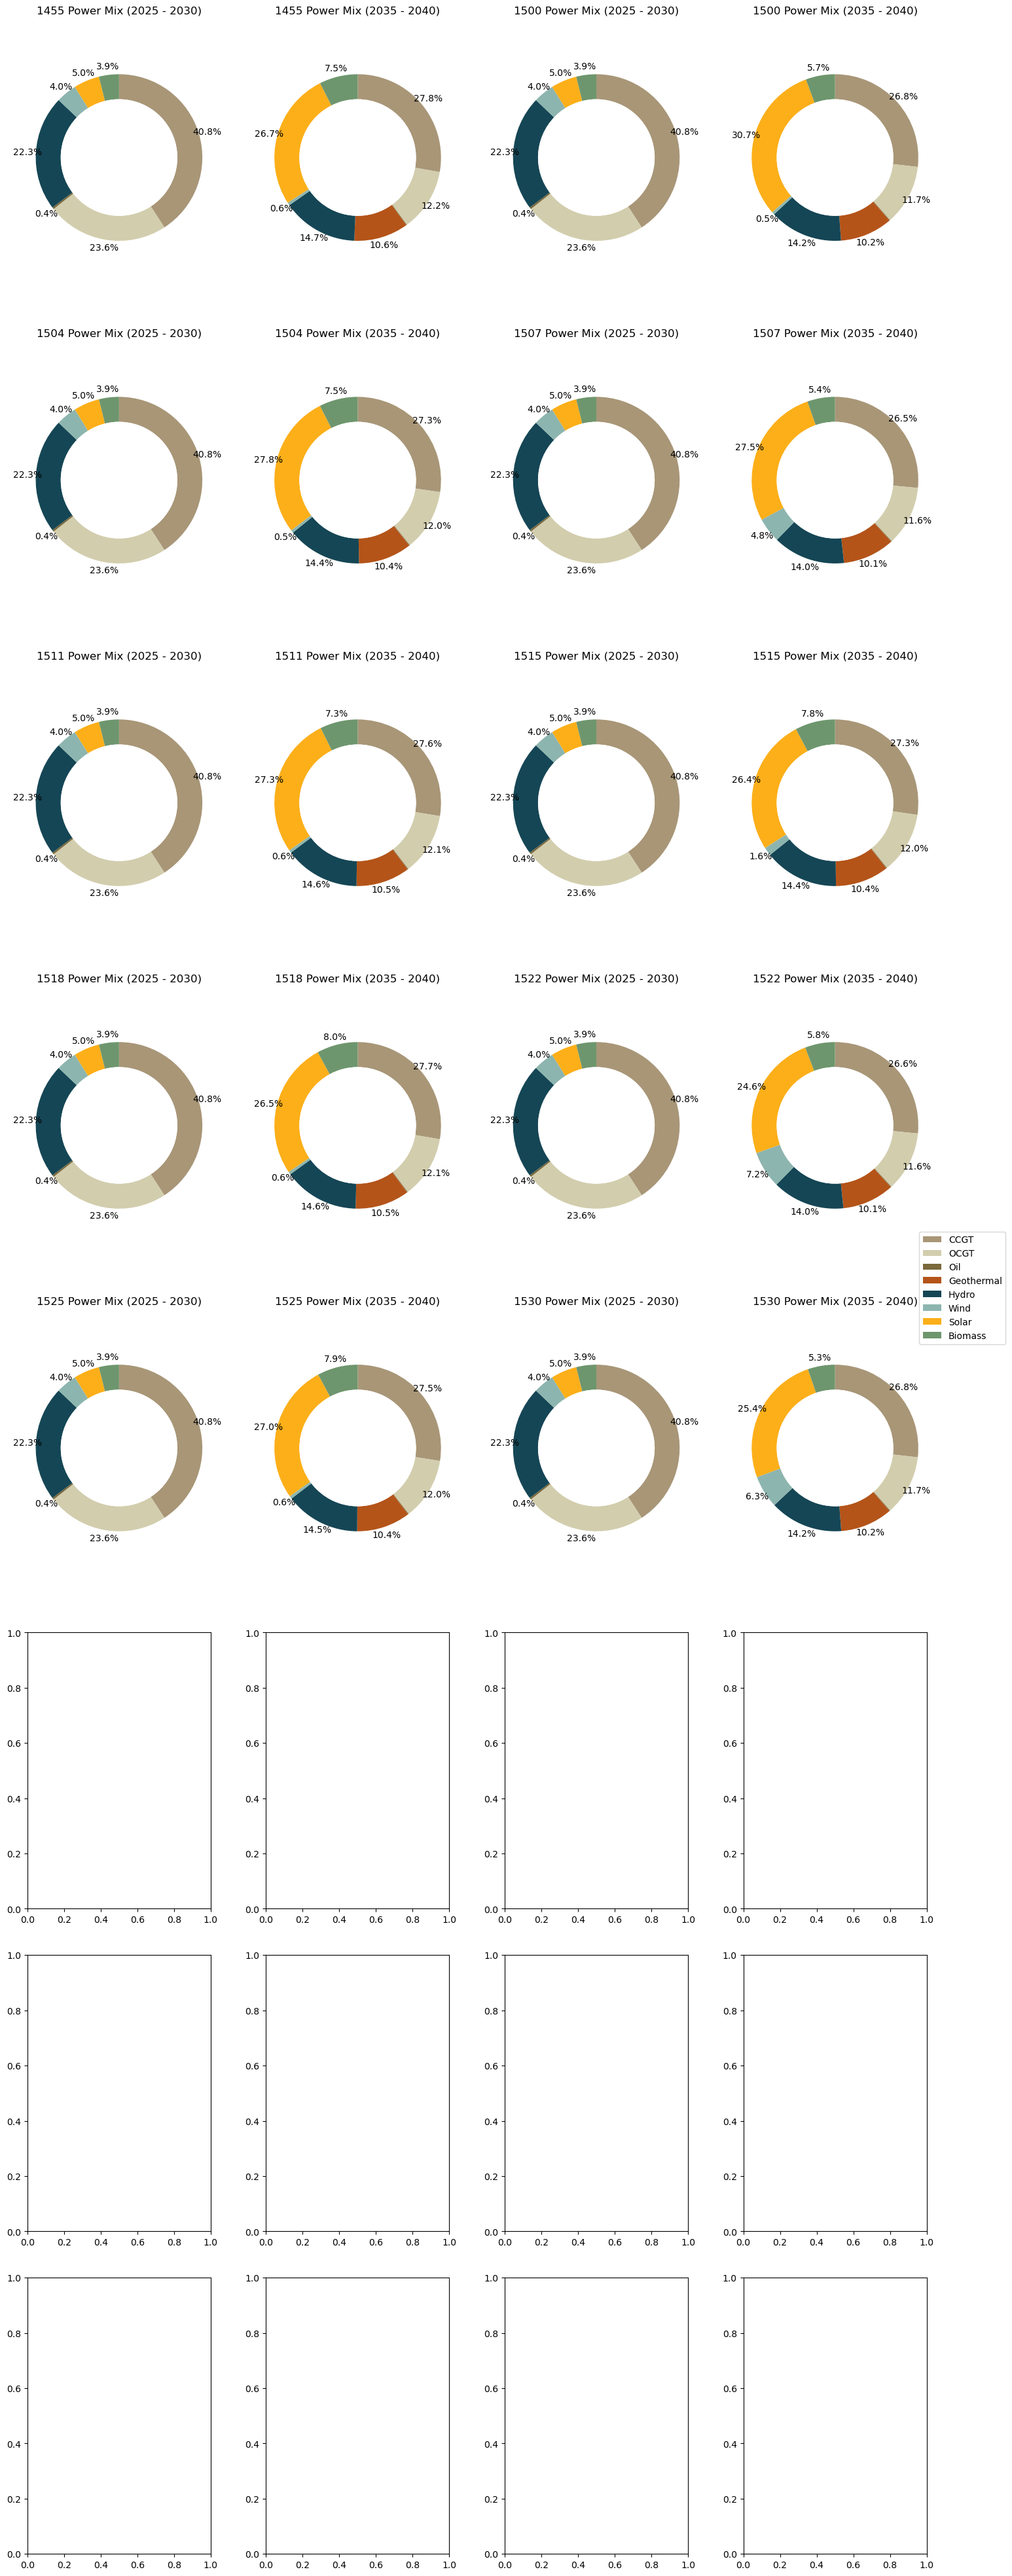

In [193]:
fig, axes = plt.subplots(8, 4, figsize=(15, 5*8))  # 8 rows for 8 time periods, 2 columns for each pair of pie charts
axes = axes.flatten()

for idx, (time, path) in enumerate(file_paths.items()):
    dispatch = open_csv(path, included_rows)
    dispatch.set_index('', inplace=True)
    for column in dispatch.columns:
        dispatch[column] = pd.to_numeric(dispatch[column], errors='coerce')
        
    dispatch = rename_columns(dispatch)
    dispatch /= 1000

    dispatch['Hydro'] = dispatch['Hydro ror'] + dispatch['Hydro storage']
    dispatch.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)
    
    
    ax1, ax2 = axes[2*idx], axes[2*idx+1]  # Adjust indexing to select correct axes

    dispatch_firstperiod = dispatch[:1][['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']]
    dispatch_lastperiod = dispatch[-1:][['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']]
    wedges1, texts1, autotexts1 = ax1.pie(
        dispatch_firstperiod.iloc[0].values, autopct=custom_autopct,
        colors=get_colors(dispatch_firstperiod.columns), startangle=90, counterclock=False, 
        wedgeprops=dict(width=0.3), pctdistance=1.1
    )

    wedges2, texts2, autotexts2 = ax2.pie(
        dispatch_lastperiod.iloc[0].values, autopct=custom_autopct,
        colors=get_colors(dispatch_lastperiod.columns), startangle=90, counterclock=False, 
        wedgeprops=dict(width=0.3), pctdistance=1.1
    )

    for autotext in autotexts1 + autotexts2:
        if autotext.get_text() <= '0.3%':
            autotext.set_visible(False)

    centre_circle1 = plt.Circle((0,0),0.70,fc='white')
    ax1.add_artist(centre_circle1)
    ax1.set_title(f"{time} Power Mix (2025 - 2030)")

    centre_circle2 = plt.Circle((0,0),0.70,fc='white')
    ax2.add_artist(centre_circle2)
    ax2.set_title(f"{time} Power Mix (2035 - 2040)")

    ax1.axis('equal')
    ax2.axis('equal')

# Adjust layout and add a common legend
fig.legend(dispatch_lastperiod.columns, loc="center right", bbox_to_anchor=(1.05, 0.5))
plt.tight_layout(pad=3.0)
plt.show()


C:\Users\marih\AppData\Local\Temp\ipykernel_30128\258652362.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshots.drop(columns=['Hydroregulated_MW'], inplace=True)
C:\Users\marih\AppData\Local\Temp\ipykernel_30128\258652362.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshots.drop(columns=['Hydroregulated_MW'], inplace=True)
C:\Users\marih\AppData\Local\Temp\ipykernel_30128\258652362.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

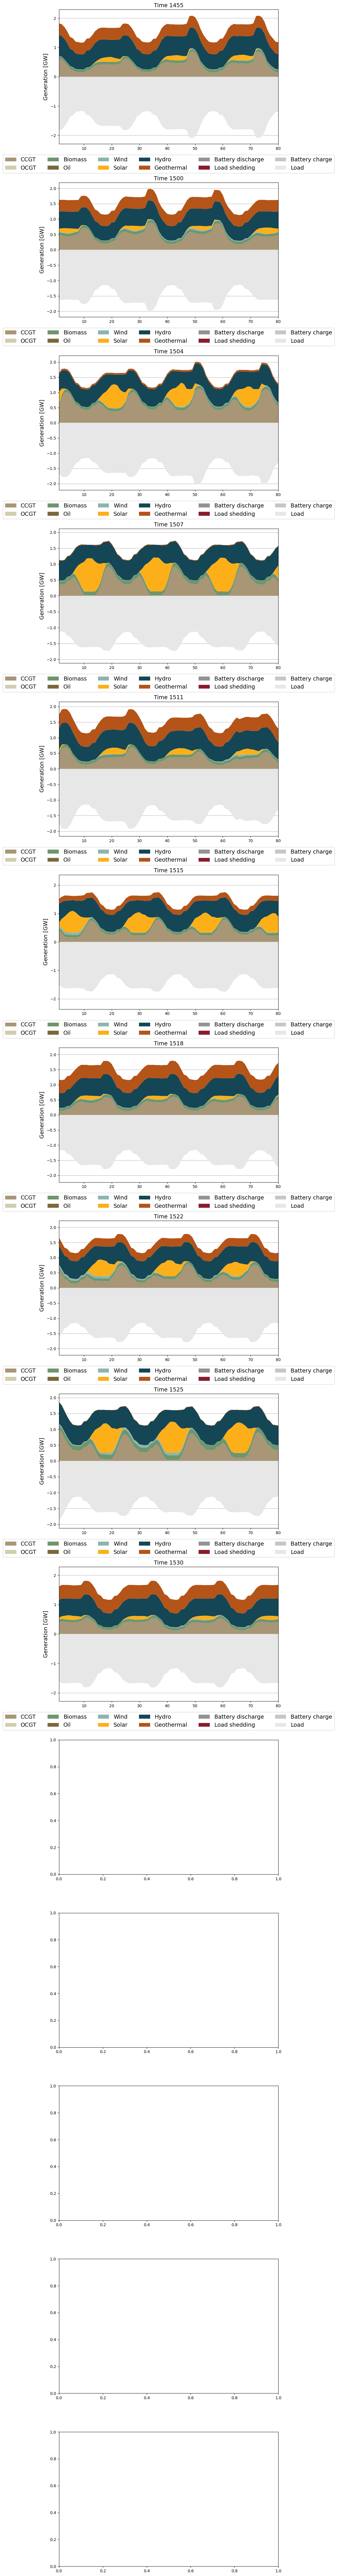

In [191]:
period = '2035-2040'
regular_seasons = ['winter', 'spring', 'summer', 'fall']
scenario_number = 'scenario1'

fig, axes = plt.subplots(15, 1, figsize=(11, 6*15))  # Adjust the size as needed
axes = axes.flatten()  # Flatten the axes array for easy looping

load_shed = {}

for ax, (time, path) in zip(axes, file_paths.items()):
    operational_data = pd.read_csv(operational_data_frames[time])
    filtered_data = operational_data[(operational_data['Period'] == period) & (operational_data['Season'].isin(regular_seasons)) & (operational_data['Scenario'] == scenario_number)]
    snapshot_columns = [tech + '_MW' for tech in old_names]
    snapshot_columns.append('storDischarge_MW')
    snapshot_columns.append('storCharge_MW')
    snapshot_columns.append('Hour')
    snapshot_columns.append('Load_MW')
    snapshot_columns.append('LoadShed_MW')
    snapshots = filtered_data[snapshot_columns]
    snapshots.loc[:,'Hydrorun-of-the-river_MW'] = snapshots['Hydrorun-of-the-river_MW'] + snapshots['Hydroregulated_MW']
    snapshots.drop(columns=['Hydroregulated_MW'], inplace=True)

    # Sum based on Hour and then plot aggregated snapshots
    snapshots = snapshots.groupby('Hour').sum()

    columns_to_plot = [col for col in snapshots.columns if col not in ['Hour', 'storCharge_MW', 'Load_MW']]
    colors= [beige2, beige3, green2, beige1, teal4, yellow, teal2, brown2, grey4, red1]
    dispatch_plot = ax.stackplot(snapshots.index, [snapshots[col]/1000 for col in columns_to_plot], colors=colors, zorder=2)
    ax.stackplot(snapshots.index, (snapshots['storCharge_MW'] + snapshots['Load_MW'])/1000, labels=['storCharge_MW'], colors=[grey3], zorder=2)
    ax.stackplot(snapshots.index, snapshots['Load_MW']/1000, labels=['Load'], colors=[grey1], zorder=2)
    #ax.set_xticks(rotation = 0, fontsize=14)
    #ax.set_yticks(fontsize=14)
    all_labels = new_names_2 + ['Battery discharge'] +['Load shedding'] + ['Battery charge'] + ['Load']
    ax.legend(labels=all_labels, loc='upper center', bbox_to_anchor=(0.5, -0.06), ncol=6, fontsize=14)
    ax.grid(axis='y', zorder=0)
    ax.set_ylabel('Generation [GW]', fontsize=14)
    ax.set_title(f"Time {time}", fontsize=14)
    ax.set_xlim(1, 80)
    
    load_shed[time] = snapshots['LoadShed_MW'].sum()

plt.tight_layout()
plt.show()
